In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def mark_vertex(coordinates, current_node, depth, vertex_num):
    coordinates[current_node] = {'coordinate': (vertex_num, depth)}
    vertex_num = vertex_num + 1
    return vertex_num

In [3]:
def dfs(G, coordinates, current_node, depth, vertex_num):
    children = list(G.adj[current_node])
    if len(children) > 2:
        print("Error input grapth." + str(len(children)) + "3 childrens.")
        exit()
    if len(children) <= 0:
        vertex_num = mark_vertex(coordinates, current_node, depth, vertex_num)
        return vertex_num
    vertex_num = dfs(G, coordinates, children[0], depth + 1, vertex_num)
    vertex_num = mark_vertex(coordinates, current_node, depth, vertex_num)
    if len(children) == 1:
        return vertex_num
    else:
        return dfs(G, coordinates, children[1], depth + 1, vertex_num)

In [4]:
def mark_graph(G):
    current_node = 'n0'
    depth = 0
    vertex_num = 0
    coordinates = {}
    dfs(G, coordinates, current_node, depth, vertex_num)
    nx.set_node_attributes(G, coordinates)
    return

In [5]:
def read_graph(file):
    G = nx.read_graphml(file)
    return G

In [6]:
def settings_graph():
    figure, axis = plt.subplots(figsize=(20, 20))
    axis.grid(True)
    node_size = 80
    return node_size, axis

In [7]:
def settings_ltd():
    shift_tree = defaultdict(int)
    shift_tree_global = defaultdict(int)
    depth = 0
    current_node = 'n0'
    return shift_tree, current_node, depth, shift_tree_global

In [8]:
def save_graph(file_path):
    plt.savefig(file_path)
    return

In [9]:
def draw_graph(file_path):
    G = read_graph(file_path + ".xml")
    mark_graph(G)
    node_size, axis = settings_graph()
    nx.draw(G, nx.get_node_attributes(G, 'coordinate'), node_size=node_size, with_labels=False, ax=axis)
    axis.invert_yaxis()
    save_graph(file_path + "-before"+ ".png")
    return

In [10]:
def max_shift_contour(contour_l, contour_r, len_contour):
    max_shift = 0
    if len_contour <= 0:
        return max_shift
    for i in range(0, len_contour):
        shift = contour_l[i][1] - contour_r[i][0] + 1
        if shift > max_shift:
            max_shift = shift
    return max_shift

In [11]:
def min_contour(contour_l, contour_r):
    return min(len(contour_l), len(contour_r))

In [12]:
def max_contour(contour_l, contour_r):
    return max(len(contour_l), len(contour_r))

In [13]:
def add_shift_contour(contour, shift):
    for i, _ in enumerate(contour):
        contour[i][0] += shift
        contour[i][1] += shift

In [14]:
def merge_contours(contour_l, contour_r):
    contours = []
    for i in range (0, max_contour(contour_l, contour_r)):
        element = []
        if i < len(contour_l):
            element.append(contour_l[i][0])
        else:
            element.append(contour_r[i][0])
        if i < len(contour_r):
            element.append(contour_r[i][1])
        else:
            element.append(contour_l[i][1])
        contours.append(element)
    return contours

In [15]:
def get_new_root(contour_l, contour_r):
    return (contour_l[0][0] if len(contour_l) > 0 else contour_r[0][0] + contour_r[0][1] if len(contour_r) > 0 else contour_l[0][1]) // 2

In [16]:
def mark_vertex_shift(coordinates, current_node, depth, shift_tree, shift_):
    coordinates[current_node] = {'coordinate': (shift_tree[current_node] + shift_, depth)}
    return

In [17]:
def dfs_shift(G, coordinates, current_node, depth, shift_tree, shift, shift_tree_global):
    children = list(G.adj[current_node])
    if len(children) > 2:
        print("Error input grapth." + str(len(children)) + "3 childrens.")
        exit()
    shift_ = shift + shift_tree_global[current_node]
    if len(children) == 0:
        mark_vertex_shift(coordinates, current_node, depth, shift_tree, shift_)
        return
    dfs_shift(G, coordinates, children[0], depth + 1, shift_tree, shift_, shift_tree_global)
    mark_vertex_shift(coordinates, current_node, depth, shift_tree, shift_)
    if len(children) == 2:
        dfs_shift(G, coordinates, children[1], depth + 1, shift_tree, shift_, shift_tree_global)
        return

In [18]:
def ltd(G, current_node, shift_tree, depth, shift_tree_global):
    children = list(G.adj[current_node])
    if len(children) > 2:
        print("Error input grapth." + str(len(children)) + "3 childrens.")
        exit()
    if len(children) <= 0:
        return [[0, 0]]
    contour_l = []
    contour_r = []
    if len(children) >= 1:
        contour_l = ltd(G, children[0], shift_tree, depth + 1, shift_tree_global)
    if len(children) == 2:
        contour_r = ltd(G, children[1], shift_tree, depth + 1, shift_tree_global)
    len_contour = min_contour(contour_l, contour_r)
    max_shift = max_shift_contour(contour_l, contour_r, len_contour)
    if len(children) == 2:
        shift_tree_global[children[1]] += max_shift
    add_shift_contour(contour_r, max_shift)
    contour = merge_contours(contour_l, contour_r)
    new_root = get_new_root(contour_l, contour_r)
    shift_tree[current_node] = new_root
    return [[new_root, new_root]] + contour

In [19]:
def draw_graph_ltd(file_path):
    current_node = 'n0'
    depth = 0
    shift = 0
    coordinates = {}
    G = read_graph(file_path + ".xml")
    shift_tree, current_node, depth, shift_tree_global = settings_ltd()
    ltd(G, current_node, shift_tree, depth, shift_tree_global)
    print(coordinates)
    print(shift_tree)
    dfs_shift(G, coordinates, current_node, depth, shift_tree, shift, shift_tree_global)
    nx.set_node_attributes(G, coordinates)
    node_size, axis = settings_graph()
    nx.draw(G, nx.get_node_attributes(G, 'coordinate'), node_size=node_size, with_labels=False, ax=axis)
    axis.invert_yaxis()
    save_graph(file_path + "-after" + ".png")

До применения алгоритма Layered-Tree-Draw для 42 нод

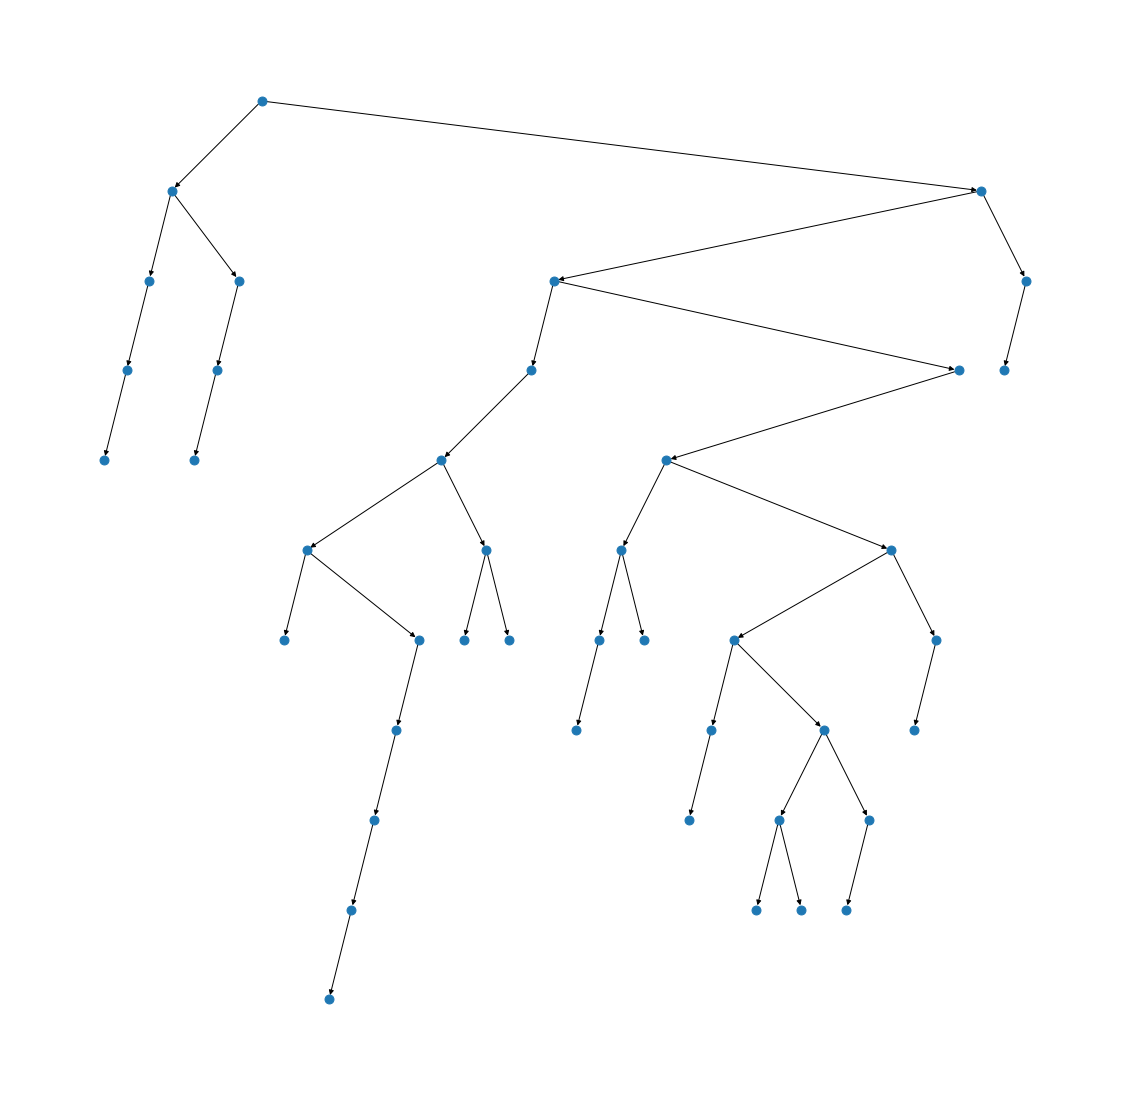

In [20]:
draw_graph('test/tree-42n')

После применения алгоритма Layered-Tree-Draw для 42 нод

{}
defaultdict(<class 'int'>, {'n3': 0, 'n2': 0, 'n6': 0, 'n5': 0, 'n1': 0, 'n17': 0, 'n16': 0, 'n15': 0, 'n14': 0, 'n12': 0, 'n19': 0, 'n11': 0, 'n10': 0, 'n25': 0, 'n24': 0, 'n30': 0, 'n33': 0, 'n36': 0, 'n32': 0, 'n29': 0, 'n38': 0, 'n28': 0, 'n23': 0, 'n22': 0, 'n9': 0, 'n40': 0, 'n8': 0, 'n0': 0})


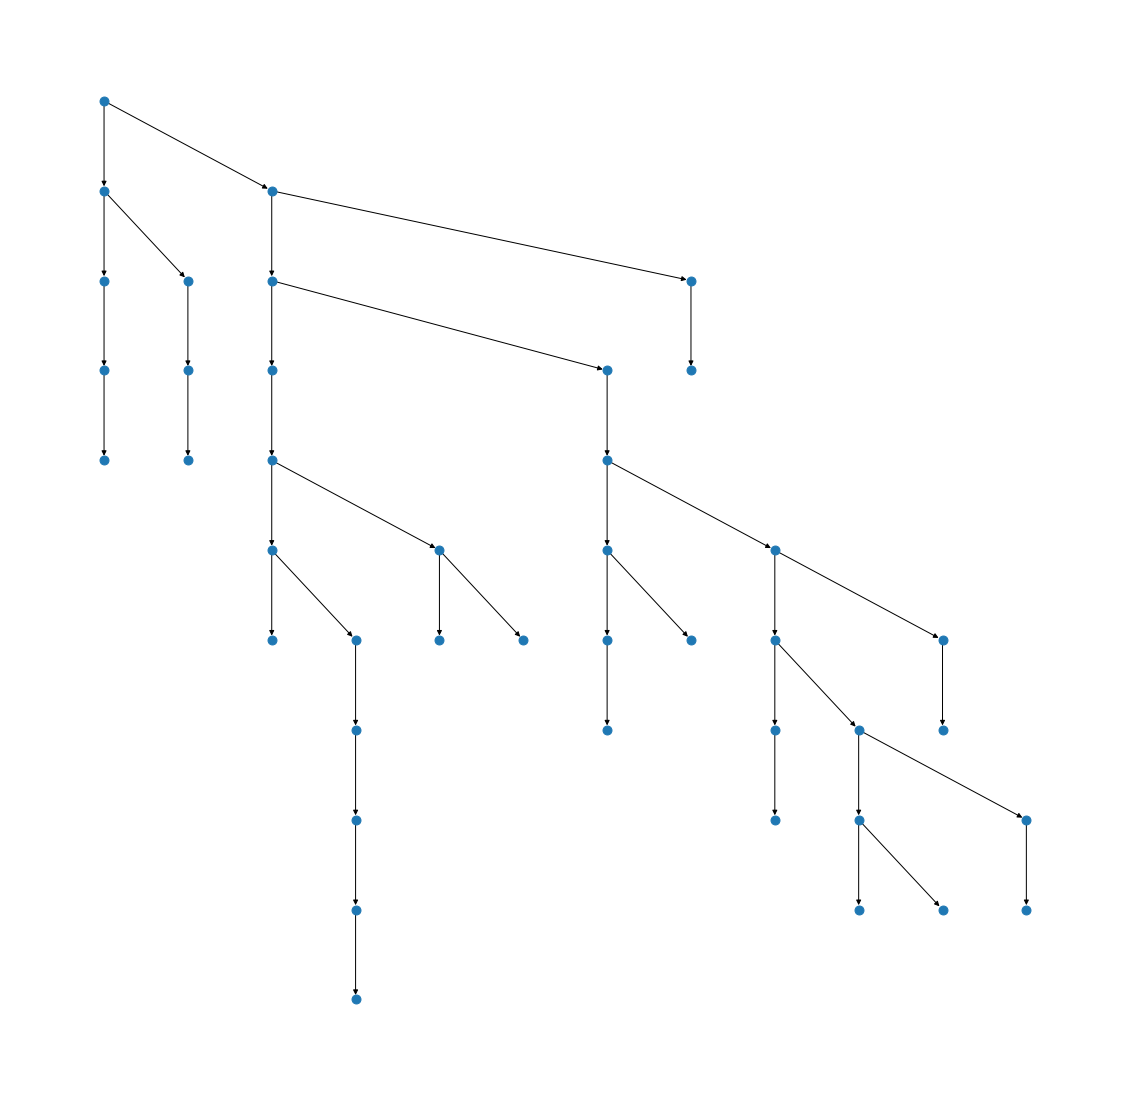

In [21]:
draw_graph_ltd('test/tree-42n')

До применения алгоритма Layered-Tree-Draw для 60 нод

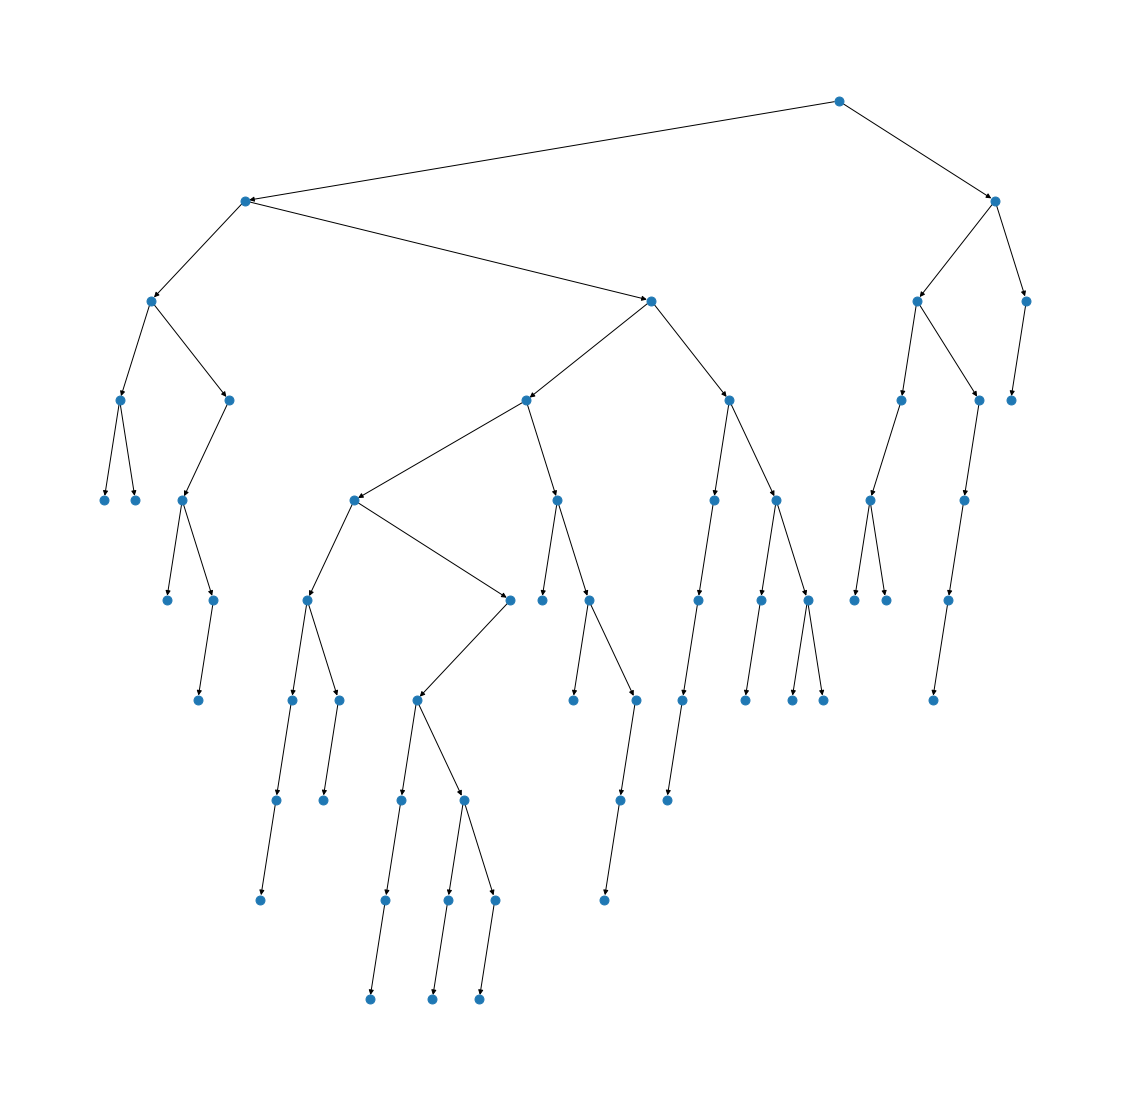

In [22]:
draw_graph('test/tree-60n')

После применения алгоритма Layered-Tree-Draw для 60 нод

{}
defaultdict(<class 'int'>, {'n3': 0, 'n9': 0, 'n7': 0, 'n6': 0, 'n2': 0, 'n16': 0, 'n15': 0, 'n18': 0, 'n14': 0, 'n23': 0, 'n22': 0, 'n26': 0, 'n28': 0, 'n25': 0, 'n21': 0, 'n20': 0, 'n13': 0, 'n35': 0, 'n34': 0, 'n32': 0, 'n30': 0, 'n12': 0, 'n40': 0, 'n39': 0, 'n38': 0, 'n43': 0, 'n45': 0, 'n42': 0, 'n37': 0, 'n11': 0, 'n1': 0, 'n51': 0, 'n50': 0, 'n56': 0, 'n55': 0, 'n54': 0, 'n49': 0, 'n58': 0, 'n48': 0, 'n0': 0})


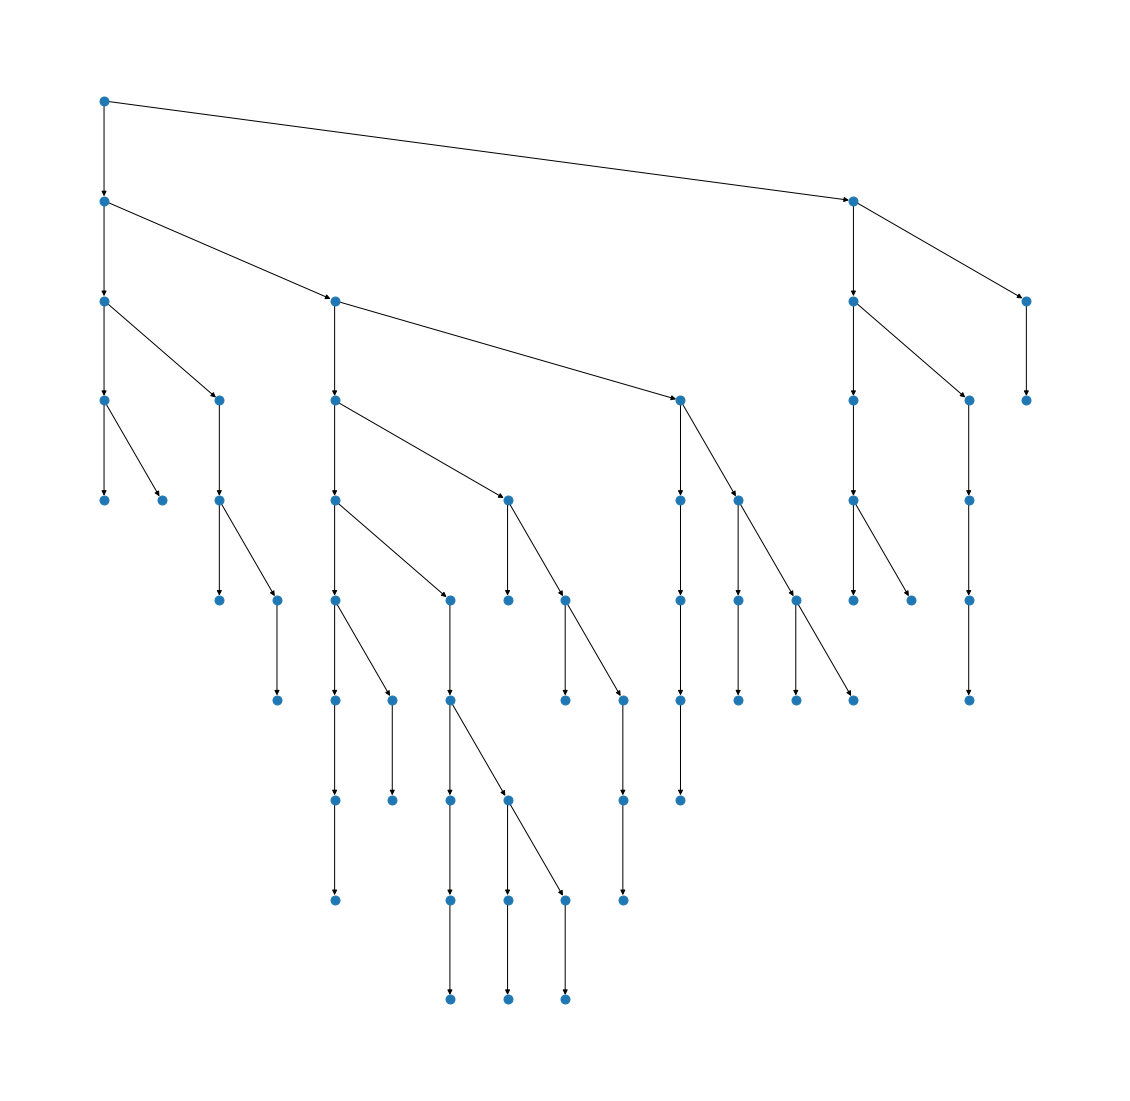

In [23]:
draw_graph_ltd('test/tree-60n')

После применения алгоритма Layered-Tree-Draw для 84 нод

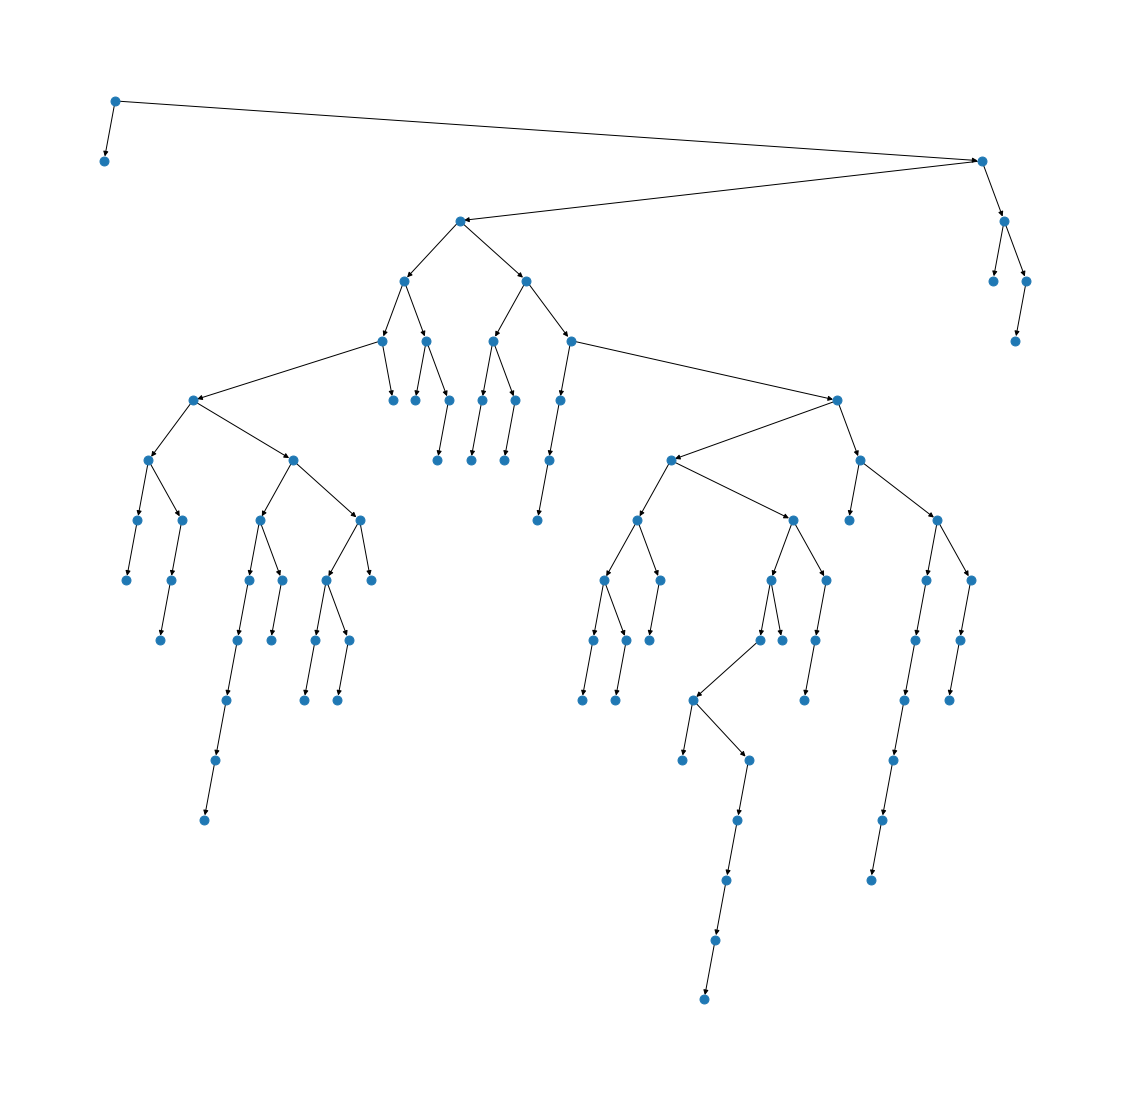

In [24]:
draw_graph('test/tree-84n')

После применения алгоритма Layered-Tree-Draw для 84 нод

{}
defaultdict(<class 'int'>, {'n8': 0, 'n11': 0, 'n10': 0, 'n7': 0, 'n18': 0, 'n17': 0, 'n16': 0, 'n15': 0, 'n20': 0, 'n14': 0, 'n24': 0, 'n26': 0, 'n23': 0, 'n22': 0, 'n13': 0, 'n6': 0, 'n5': 0, 'n32': 0, 'n30': 0, 'n4': 0, 'n36': 0, 'n38': 0, 'n35': 0, 'n42': 0, 'n41': 0, 'n48': 0, 'n50': 0, 'n47': 0, 'n52': 0, 'n46': 0, 'n62': 0, 'n61': 0, 'n60': 0, 'n59': 0, 'n57': 0, 'n56': 0, 'n55': 0, 'n66': 0, 'n65': 0, 'n54': 0, 'n45': 0, 'n75': 0, 'n74': 0, 'n73': 0, 'n72': 0, 'n71': 0, 'n78': 0, 'n77': 0, 'n70': 0, 'n68': 0, 'n44': 0, 'n40': 0, 'n34': 0, 'n3': 0, 'n82': 0, 'n80': 0, 'n2': 0, 'n0': 0})


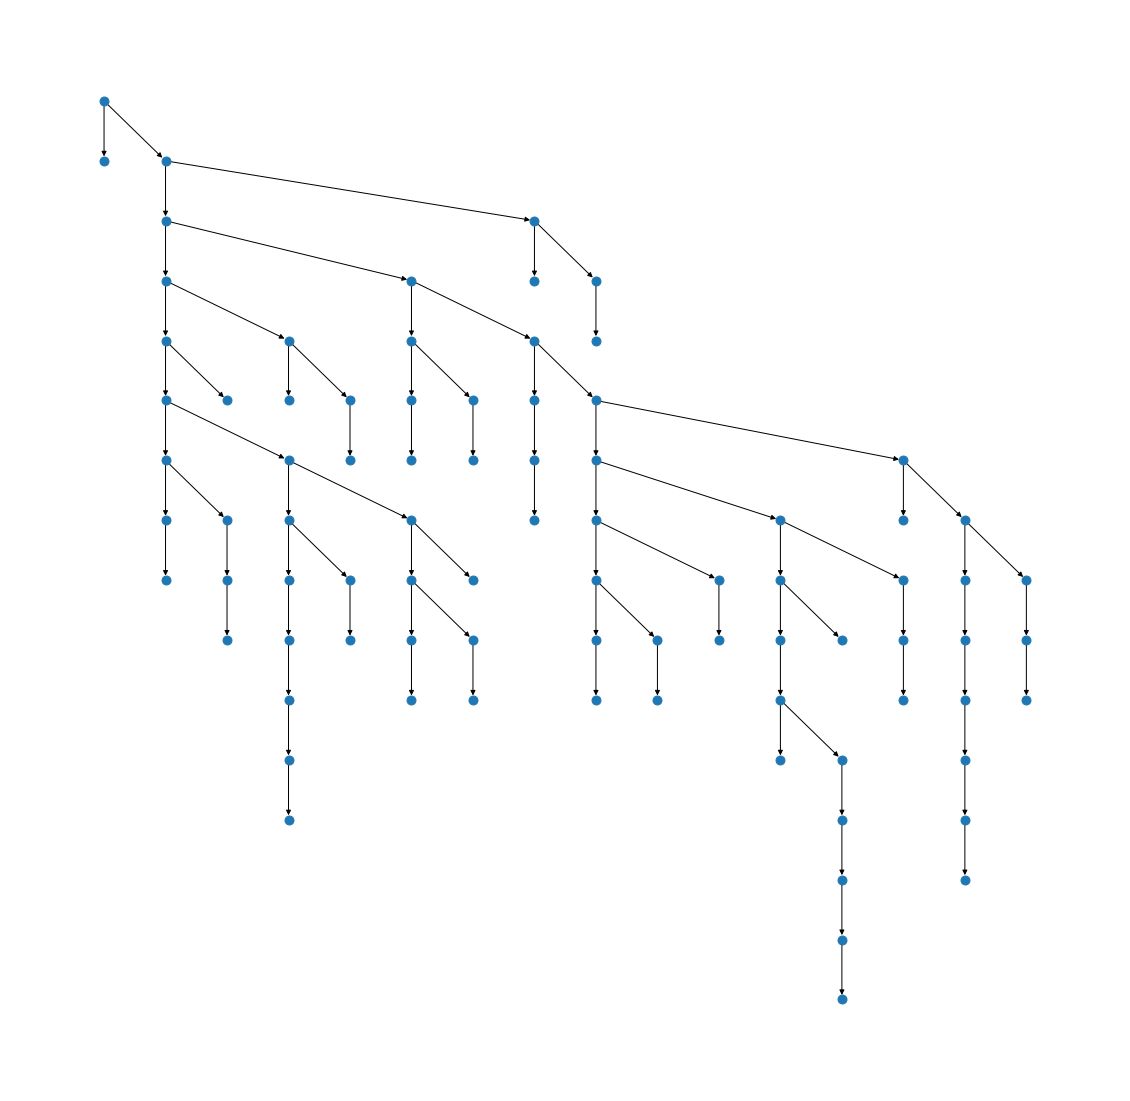

In [25]:
draw_graph_ltd('test/tree-84n')